# Quantum Approximation Optimization Algorithm (QAOA)

## Task 4

The goal in this problem is to generalize the MaxCut problem for the case of a weighted graph using the QAOA algorithm.  
This task is divided as,

4) Solution
4.1) MaxCut Problem
4.2) The Quantum Approximation Optimization Algorithm
4.3) The Ising model
4.4) The Mixer
4.5) Trotterization
4.5.1) Trotterization in our problem
4.6) Cost Function
4.7) Example
4.7.1) Optimization
4.7.2) Visualization
4.8) New approach

## 4 Solution
Before solve the problem, we need to have an understanding ot the QAOA algorithm and the MaxCut problem.

### 4.1 MaxCut Problem
The maxCut problem is a combinatorial optimization problem (COP), where given a graph we need to find the best way to cut the graph's nodes into two sets {S, T} to maximize the number of edges' weights between the two subsets. This kind of problem is an NP-complete problem which means that the complexity to solve increases with $a^N$ where $a$ is a constant and $N$ is the number of edges of the problem.

### 4.2 The Quantum Approximation Optimization Algorithm

The QAOA is a quantum algorithm that tries to come to the vicinity of the ground state of a Hamiltonian $H_C$. To accomplish this, the algorithm uses a concept from the Adiabatic Quantum Computation (AQC) which says that if we start from a  Hamiltonian with a known ground state $H_S$ and slowly we transform it into the desired Hamiltonian $H_C$ we can obtain the ground state of the Hamiltonian $H_C$. This process is represented by the equation $H(\alpha) = (1-\alpha)H_B + \alpha H_C$ where $\alpha$ is a slow parameter modification. However, the QAOA algorithm does not do this whit a slow modification of the parameters. First, we need to translate the Hamiltonians for unitary transformations that are the way it is represented in a quantum computer. The unitary Evolution for the cost Hamiltonian $U_C(\gamma) = e^{-i\gamma H_C}$ and for the simple Hamiltonian is $U_B = e^{-i\beta H_B}$ where $\gamma$ and $\beta$ are the parameters that we will change. Then, the idea of the QAOA is to obtain the state

$$|\psi(\gamma, \beta)⟩ = U(H_B,\beta_p)U(H_C,\gamma_p)...U(H_B,\beta_1)U(H_C,\gamma_1)|s⟩ \tag{1}$$

where $p$ is the total number of step of the algorithm, $|s⟩$ is the initial configuration of the qubits (usually in a superposition state).

In [1]:
# We are going to work this problem in qiskit
import networkx as nx # For plotting the graphs
import matplotlib.pyplot as plt
import numpy as np
import qiskit as qk
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
from scipy.linalg import expm

backend = qk.Aer.get_backend('qasm_simulator')
%matplotlib inline

### 4.3 The Ising model
Now, we need to know how we can encode the maxcut problem. For this purpose, we can use an Ising model

$$H_C = -\sum_{<i,j>}J_{ij}\sigma^z_i \sigma^z_j$$

where $\sigma^z_i$ represent the nodes of the graph and $J_{ij}$ is the interaction between two different nodes (weights of the edges).
However, in a quantum computer, we cannot introduce directly the Hamiltonian, we need to come with the representation of this Hamiltonian in a unitary evolution, as

$$U = e^{-i\gamma H_C}$$

We can describe the unitary transformation of this problem  with the circuit,

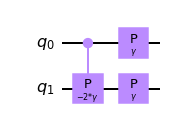

In [2]:
qc = qk.QuantumCircuit(2, name='U')
gamma = qk.circuit.Parameter(r"$\gamma$")
qc.cp(-2 * gamma, 0, 1)
qc.p(gamma, 0)
qc.p(gamma, 1)
qc.draw("mpl")

In [3]:
def cost_unitary(gamma, qubits, G):
    """
    This function returns the unitary representation of the Ising Hamiltonian for the MaxCut problem.

    Parameters
    ----------
    gamma : float.
        The angle of rotation for the unitary evolution.
    G : networkx object
        Graph state of the problem. Contain the information of the nodes, edges, and weights.

    Returns
    -------
    qc : qiskit quantum circuit
        Circuit with the unitary evolution of a ZZ interaction with angle gamma times the weight.
    """
    qc = qk.QuantumCircuit(qubits, name='cost_unitary')
    E = G.edges()
    for index in E:
        v0 = index[0]
        v1 = index[1]
        weight = G[v0][v1]['weight']
        qc.cp(-2 * gamma * weight, v0, v1)
        qc.p(gamma * weight, v0)
        qc.p(gamma * weight, v1)
    return qc

### 4.4 The Mixer
The mixer is the simple Hamiltonian $H_B$ that is going to allow the transition to $H_C$. In fact, this is going to allow the exploration for the whole Hilbert space to arrive at the desired ground state of the Hamiltonian $H_C$. This is taken as $\sigma_x$ to avoid the commutation with the Hamiltonian $H_C$.

$$H_B = \sum_i^N \sigma_x \tag{2}$$

where N is the number of qubits.

In [4]:
def mixer_unitary(beta, qubits, imp=False):
    """
    This function returns the unitary evolution of the mixer Hamiltonian.

    Parameters
    ----------
    beta : float.
        The angle of rotation for the unitary evolution of the mixer.
    qubits : int
        Number the qubits (vertices).
    imp: Boolean
        Improvement in the solution (see section 4.9)

    Returns
    -------
    qc : qiskit circuit
        Circuit with an x-rotation of every qubit.
    """
    qc = qk.QuantumCircuit(qubits, name='mixer_unitary')
    if imp:
        qc.rx(2 * beta, range(1,qubits))
    else:
        qc.rx(2 * beta, range(qubits))
    return qc

# 4.5 Trotterization

Before, we mention that we are doing a process similar to that of the AQC where we have the Hamiltonian $H(\alpha) = (1-\alpha)H_B + \alpha H_C$ but how do we represent this Hamiltonian as a unitary evolution and how do we come to the Hamiltonian of Eq. 1. The answer is using the Trotterization, an approximation formula for the exponential form of the sum of two matrices. The Trotterization comes with the formula

$$e^{A + B} = \lim_{n\rightarrow\infty}(e^{A/n} e^{B/n})^n \tag{3}$$

Let's see this with an example

Whit n = 20, Difference with the ideal value of U 9.944479251433049e-15
Whit n = 1, Difference with the ideal value of U 1.317581729331778e-09


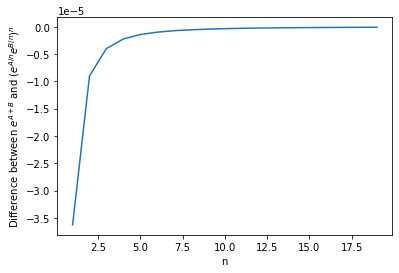

In [5]:
sz = np.array([[1, 0],[0, -1j]]) #sigma_z Pauli matrix
sx = np.array([[0,1],[1,0]]) # sigma_x Pauli matrix
steps = 20 # number of steps of n
gamma = 0.1
beta = 0.5
H_C = gamma * np.kron(sz,sz)
H_B = beta * np.kron(sx,sx)
alpha = 0.7
U1 = expm(1j*((1 - alpha) * H_C + alpha * H_B))
def U(n):
    u = np.linalg.matrix_power(expm(1j * (1 - alpha) *H_C / n) @ expm(1j* alpha * H_B / n),n)
    return u
diff = [np.sum(U1 - U(n)).real for n in range(1,steps)]
plt.figure()
plt.plot(np.arange(1,steps),diff)
plt.xlabel("n")
plt.ylabel(r"Difference between $e^{A+B}$ and $(e^{A/n}e^{B/n})^n$")
print(fr"Whit n = {steps}, Difference with the ideal value of U {(diff[-1]*diff[-1].conjugate()).real}")
print(fr"Whit n = {1}, Difference with the ideal value of U {(diff[0]*diff[0].conjugate()).real}")

### 4.5.1 Trotterization in our problem

Here, we can see with a small number of steps we can approximate the $e^{A+B}$ into $(e^{A/n}e^{B/n})^n$ and just 1 step is really closed to $e^{A+B}$. Therefore, we can approximate 

$$e^{j (\gamma H_C + \beta H_B)} = e^{j \gamma H_C} e^{j \beta H_B}\tag{4}$$

Now, we can define the different parameter $\gamma$ and $\beta$ for the state in Eq. 1 that work as the $(1 - \alpha)$ and $\alpha$ of the AQC. A function with this implementation is shown below.

In [52]:
def ground_circuit(params, G, depth, shots, imp=False):
    """
    This function returns the unitary evolution of the Eq. 1.

    Parameters
    ----------
    params : list.
        List of angles gamma and beta with size equal to the depth.
    G : networkx graph
        Graph with the information of number of vertices, edges and weights.
    depth : int
        number of steps the unitarity is applied.
    shots: int
        Circuit number of repetition of the quantum circuit (To get the statistics)
    imp: Boolean
        Improvement described in section 4.9

    Returns
    -------
    qc : qiskit circuit
        Circuit with a x-rotation of every qubit.
    """
    qubits = len(G.nodes())
    gamma = [params[i] for i in range(0, 2 * depth, 2)]
    beta = [params[i] for i in range(1, 2 * depth, 2)]
    
    gamma_p = qk.circuit.Parameter(r'$\gamma$')
    beta_p = qk.circuit.Parameter(r'$\beta$')
    U_mixer = mixer_unitary(beta_p, qubits, imp)
    U_cost = cost_unitary(gamma_p, qubits, G)

    circuit = qk.QuantumCircuit(qubits, qubits)
    if imp:
        circuit.h(range(1,qubits)) #Fixing one qubit
    else:
        circuit.h(range(qubits))
            
    for i in range(depth):
        circuit += U_cost.assign_parameters({gamma_p:gamma[i]})
        circuit += U_mixer.assign_parameters({beta_p:beta[i]})
        
    circuit.measure(range(qubits), range(qubits))
    job = qk.execute(circuit, backend = backend, shots = shots)
    results = job.result()
    return results    

### 4.6 Cost Function
The information from the quantum circuit is interpreted as follows, if the result of measure a qubit is 0 then it belongs to the set $S$ and to the set $T$ otherwise (see section 4.1). 
Instead of doing many steps until we get closed to the ground state, we can define a cost function using a classical optimization algorithm and minimize it. Finding the set of angles $\gamma_p$ and $\beta_p$ that best minimize this cost function. Below is an example of this cost function, where we are minimizing

$$ C_{ij} = w_{ij}(z_i(1 -  z_j) + z_j(1 -  z_i))\tag{5}$$

where $z_i$ is 1 if we measure the ith qubit and it is in state 0 and 0 if we measure it and it is in state 1. Therefore, if node i has different value to node j $C_{ij} = w_{ij}$ and 0 otherwise.

In [42]:
def cost_func(params, G, depth, shots, imp=False):
    """
    This function returns the cost function Eq. 5 for the circuit created with the function ground_circuit.

    Parameters
    ----------
    params : list.
        List of angles gamma and beta with size equal to the depth.
    G : networkx graph
        Graph with the information of number of vertices, edges and weights.
    depth : int
        number of steps the unitarity is applied.
    shots: int
        Circuit number of repetition of the quantum circuit (To get the statistics)
    imp: Boolean
        Improvement described in section 4.9
    Returns
    -------
    qc : qiskit circuit
        Circuit with a x-rotation of every qubit.
    """
    result = ground_circuit(params, G, depth, shots, imp) # Eq.1
    counts = result.get_counts() # Result of the simulation of the circuit
    E = G.edges()
    cost = 0
    for sample in list(counts.keys()):
        x = [int(num) for num in sample]
        C = 0
        for index in E:
            v0 = index[0] # vertex 1
            v1 = index[1] # vertex 2

            w = G[v0][v1]['weight']
            C -= w * (x[v0] * (1 - x[v1]) + x[v1] * (1 - x[v0]))
        cost += (counts[sample] * C)/shots
    if np.random.rand() > 0.5:
        print(f"Cost: {cost}")
    return cost

### 4.7 Example
Below is an example of the application of the QAOA for 5 nodes using the simulator of qiskit.

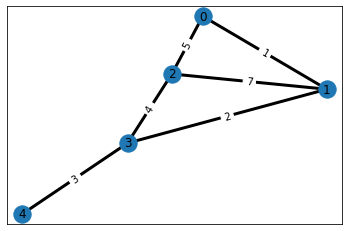

In [8]:
# Initializing parameters
qubits = 5 #nodes
shots = 1024 # Outcomes of the circuit to get a distribution of states
depth = 5 # How many stes of U_C U_B we apply 
G = nx.Graph()
G.add_nodes_from(np.arange(qubits)) # Nodes
edges = [(0,1,1),(0,2,5),(1,2,7),(2,3,4),(1,3,2),(3,4,3)] #Information of the Graph where each tuple (node 1, node2, weight)
G.add_weighted_edges_from(edges)

labels = {e: G[e[0]][e[1]]['weight'] for e in G.edges}
pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility
nx.draw_networkx_nodes(G, pos, node_size=300)
# edges
nx.draw_networkx_edges(G, pos, width=3)
# labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10)
plt.show()

#### 4.7.1 Optimization

In [9]:
init = [np.pi * (1 - 2*np.random.rand()) for i in range(2*depth)] # Random initialization of the angles gamma and beta
out = minimize(cost_func, x0=init, args = (G, depth, shots), method="COBYLA", options={'maxiter':200}) # Classical optimization
print(out)
optimal_params = out['x']  
res_opt = ground_circuit(optimal_params, G, depth, shots) #This is the output with the optimized angles gamma and beta

Cost: -9.9404296875
Cost: -12.296875
Cost: -11.693359375
Cost: -9.6435546875
Cost: -9.3955078125
Cost: -9.02734375
Cost: -10.9033203125
Cost: -10.7744140625
Cost: -13.091796875
Cost: -11.10546875
Cost: -12.736328125
Cost: -12.541015625
Cost: -12.2158203125
Cost: -12.73046875
Cost: -12.8486328125
Cost: -13.716796875
Cost: -12.734375
Cost: -13.2275390625
Cost: -13.85546875
Cost: -14.1591796875
Cost: -13.9189453125
Cost: -13.90234375
Cost: -13.775390625
Cost: -14.1474609375
Cost: -14.0126953125
Cost: -13.7138671875
Cost: -14.2109375
Cost: -14.154296875
Cost: -14.146484375
Cost: -14.0068359375
Cost: -14.369140625
Cost: -14.2998046875
Cost: -14.5322265625
Cost: -14.5224609375
Cost: -14.361328125
Cost: -14.201171875
Cost: -14.427734375
Cost: -14.4853515625
Cost: -14.3984375
Cost: -14.2041015625
Cost: -14.333984375
Cost: -14.3857421875
Cost: -14.7529296875
Cost: -14.3662109375
Cost: -14.41015625
Cost: -14.53125
Cost: -14.31640625
Cost: -14.4462890625
Cost: -14.65625
Cost: -14.3310546875
Cost:

#### 4.7.2 Visualization
Here, it is plotted the histogram of the optimized circuit. the highest bar is the state with greater probability and therefore the solution of the MaxCut problem.  

Candidates to solve MaxCut for the problem:
MaxCut: 11010 with % 12.5
MaxCut: 00101 with % 12.5


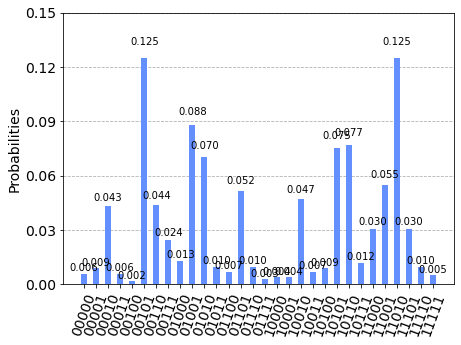

In [18]:
counts = res_opt.get_counts()
sort = sorted(counts.keys(), key=(lambda key: counts[key]),reverse=True)
best_cut = sort[0]
print("Candidates to solve MaxCut for the problem:")
for i in sort:
    if counts[i]/shots > 0.1:
        print(f"MaxCut: {i} with % {round(100*counts[i]/shots,1)}")
plot_histogram(counts)

#### 4.7.3 Visualization of the graph cutted

In [11]:
def graph_cut(cut):
    colors = [] 
    for node in G.nodes():
        if cut[node] == '0':
            colors.append("turquoise")
        else:
            colors.append("royalblue")


    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if colors[u] == colors[v]]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if colors[u] != colors[v]]

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color = colors)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=16)
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.plot([],[],'--',color='b', label="cut")
    plt.legend()
    plt.show()

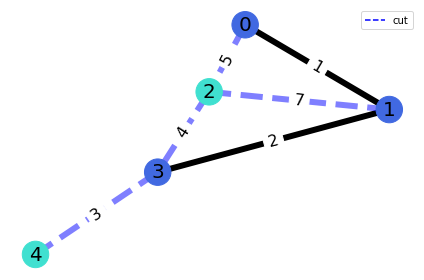

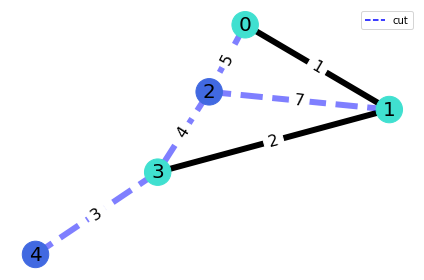

In [12]:
graph_cut(sort[0])
graph_cut(sort[1])

### 4.8 Conclusion
Throughout this notebook, we have used the tool of QAOA to obtain the solution for the maxCut problem. The problem explored above give us a result with a max weight of 19 with two possible options as we see above 11010 and 00101. I have generalized the function to work with the weights of the edges where we just need to add the weights to the cost function and the ground circuit. There are options for improvement, having into account that there are two optimal solutions for this problem, if one restricts one of the qubits to have a defined state, we can restrict to just one of these solutions.

### 4.9 Improvement
As I mention in the conclusions, there is a way to improve the solution and this is fixing one of the qubits to restrict the qubit to be in the state 0. In this way, if we restrict qubit 0 to be in state 0 and not vary we reduce the set of solutions. Below this implementation is shown. However, to the conclusion of this task, I cannot be sure about this hypothesis because the state that I got is the opposite of what I was thinking as the output state. Further research in the initial condition is needed. 

In [62]:
init = [np.pi * (1 - 2*np.random.rand()) for i in range(2*depth)] # Random initialization of the angles gamma and beta
out_imp = minimize(cost_func, x0=init, args = (G, depth, shots, True), method="COBYLA", options={'maxiter':200}) # Classical optimization
print(out_imp)
optimal_params_imp = out_imp['x']  
res_opt_imp = ground_circuit(optimal_params_imp, G, depth, shots,imp=True) #This is the output with the optimized angles gamma and beta

Cost: -11.869140625
Cost: -13.349609375
Cost: -8.73046875
Cost: -11.7158203125
Cost: -10.0830078125
Cost: -11.5625
Cost: -12.056640625
Cost: -12.9248046875
Cost: -13.7041015625
Cost: -12.958984375
Cost: -12.3681640625
Cost: -9.28515625
Cost: -13.7822265625
Cost: -13.7294921875
Cost: -13.8486328125
Cost: -13.3056640625
Cost: -14.83203125
Cost: -13.9912109375
Cost: -12.7421875
Cost: -14.9404296875
Cost: -15.4755859375
Cost: -15.1103515625
Cost: -15.5390625
Cost: -15.4287109375
Cost: -15.283203125
Cost: -15.6767578125
Cost: -15.306640625
Cost: -15.095703125
Cost: -15.5224609375
Cost: -15.4267578125
Cost: -15.541015625
Cost: -15.3984375
Cost: -15.458984375
Cost: -15.552734375
Cost: -15.6171875
Cost: -15.47265625
Cost: -15.43359375
Cost: -15.6181640625
Cost: -15.5322265625
Cost: -15.6201171875
Cost: -15.4970703125
Cost: -15.435546875
Cost: -15.6591796875
Cost: -15.6201171875
Cost: -15.6279296875
Cost: -15.3046875
Cost: -15.56640625
Cost: -15.6376953125
Cost: -15.4658203125
Cost: -15.6191406

Candidates to solve MaxCut for the problem:
MaxCut: 11010 with % 32.0
MaxCut: 00110 with % 19.1
MaxCut: 11000 with % 14.7
MaxCut: 10110 with % 12.1


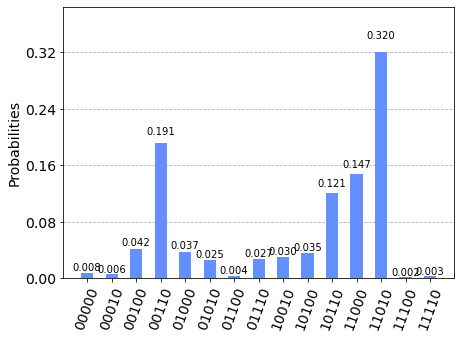

In [63]:
counts_imp = res_opt_imp.get_counts()
sort_imp = sorted(counts_imp.keys(), key=(lambda key: counts_imp[key]),reverse=True)
best_cut = sort_imp[0]
print("Candidates to solve MaxCut for the problem:")
for i in sort_imp:
    if counts_imp[i]/shots > 0.1:
        print(f"MaxCut: {i} with % {round(100*counts_imp[i]/shots,1)}")
plot_histogram(counts_imp)

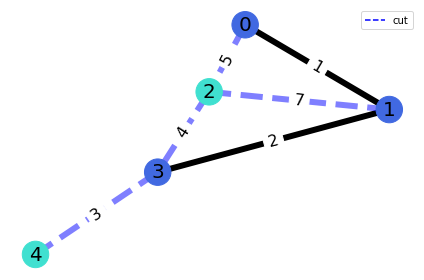

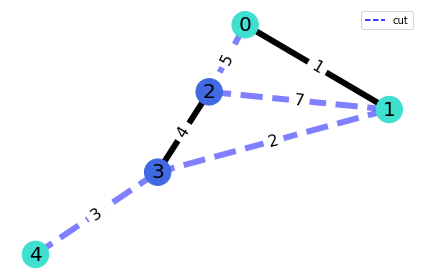

In [64]:
graph_cut(sort_imp[0])
graph_cut(sort_imp[1])